In [1]:
import os
import json
import pandas as pd
from typing import Dict, Any
from urllib.request import urlretrieve
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
from shapely import wkt
import openrouteservice
import polars as pl
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge


## Preforcast Preprocessing

In [2]:
df = pd.read_csv('../data/curated/forcast_dataset.csv')

In [3]:
df.sort_values(by=['year','month'], inplace=True)

In [4]:
df.value_counts(['year'], ascending=True)


year
2018        60
2019        97
2020       184
2021       448
2022       660
2023       955
2024     11977
2017    149572
2016    155236
2015    165369
Name: count, dtype: int64

In [5]:
sum(df.isnull().sum())

0

In [6]:
df.columns
df.drop(['longitude','latitude','Year'], axis=1, inplace=True)

In [7]:
df.columns

Index(['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking',
       'distance_to_cbd', 'nearst_train_station_dist', 'year', 'month',
       'num_primary', 'num_secondary_public', 'num_secondary_private',
       'num_secondary_catholic', 'num_edu_centre', 'v_high_vcaa', 'high_vcaa',
       'good_vcaa', 'property_type_apartment / unit / flat',
       'property_type_duplex', 'property_type_duplex-semi-detached',
       'property_type_house', 'property_type_retirement living',
       'property_type_serviced apartment', 'property_type_studio',
       'property_type_townhouse', 'property_type_villa', 'lga',
       'Rate per 100,000 population', 'lga_population'],
      dtype='object')

In [8]:
suburbs  = df['suburb'].unique()



In [9]:
df_suburb = df['suburb'].value_counts()
df_suburb = df_suburb.reset_index()
df_suburb.columns = ['suburb','count']
could_drop = df_suburb[df_suburb['count'] < 40 ]
could_drop.sum()


# drop suburbs with less than 40 entries
df = df[~df['suburb'].isin(could_drop['suburb'])]

In [10]:
len(df['suburb'].unique())

588

## Quick feature aggregation 

In [11]:
df['avg_distance_to_cbd'] = df.groupby('suburb')['distance_to_cbd'].transform('mean')
df['avg_rent_by_suburb'] = df.groupby('suburb')['rent'].transform('mean')
df['median_rent_by_suburb'] = df.groupby('suburb')['rent'].transform('median')

df.drop('distance_to_cbd', inplace=True, axis=1)

In [12]:
df.columns

Index(['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking',
       'nearst_train_station_dist', 'year', 'month', 'num_primary',
       'num_secondary_public', 'num_secondary_private',
       'num_secondary_catholic', 'num_edu_centre', 'v_high_vcaa', 'high_vcaa',
       'good_vcaa', 'property_type_apartment / unit / flat',
       'property_type_duplex', 'property_type_duplex-semi-detached',
       'property_type_house', 'property_type_retirement living',
       'property_type_serviced apartment', 'property_type_studio',
       'property_type_townhouse', 'property_type_villa', 'lga',
       'Rate per 100,000 population', 'lga_population', 'avg_distance_to_cbd',
       'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

In [13]:
# df['bath_bed_toghether'] = df['num_bathrooms'] + df['num_bedrooms']
# df['bath_bed_int'] =  df['num_bathrooms']*df['num_bedrooms']


# df.drop(['num_bathrooms','num_bedrooms'], axis=1, inplace=True)

<Axes: xlabel='date'>

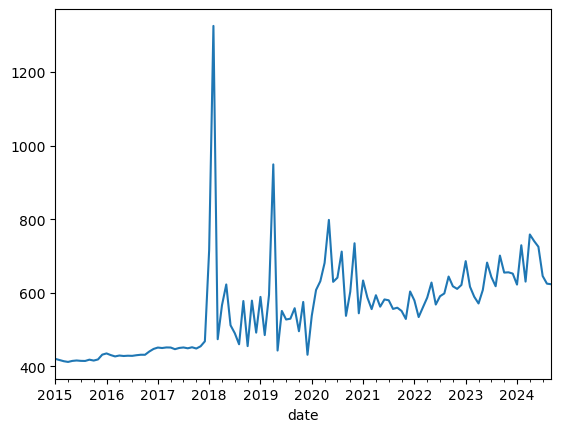

In [14]:
# draw time series plot for rent 
df_draw = df.copy()
df_draw['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df_draw.set_index('date', inplace=True)
df_draw.drop(['year', 'month'], axis=1, inplace=True)

df_draw_plot = df_draw.groupby('date')['rent'].mean()
df_draw_plot.plot()




### Minor Preprocessing

In [15]:


df_reg = df.copy()
df_reg_sub = df_reg[['suburb']]
df_reg.drop(['suburb'], axis=1, inplace=True)
df_reg.drop(['lga'],axis=1, inplace=True)

X = df_reg.drop('rent', axis=1)
y = df_reg['rent']

X_train = X.loc[df_reg['year'] < 2022]
X_test = X.loc[df_reg['year'] >= 2022]
y_train = y.loc[df_reg['year'] < 2022]
y_test = y.loc[df_reg['year'] >= 2022]

df_reg_sub_train = df_reg_sub.loc[df_reg['year'] < 2022]
df_reg_sub_test = df_reg_sub.loc[df_reg['year'] >= 2022]

# y_test = np.log(y_test)
# y_train = np.log(y_train)


In [16]:
df['suburb']

2351               corio
3910            seabrook
18848          southbank
20349             ormond
22522           hawthorn
               ...      
484542          box hill
484546           tarneit
484547         glen iris
484548    gladstone park
484550        shepparton
Name: suburb, Length: 478412, dtype: object

# Dummy model

In [17]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean") 
dummy_model.fit(X_train, y_train) 

y_dummy_pred = dummy_model.predict(X_test)

dummy_mse = mean_squared_error(y_test, y_dummy_pred)
dummy_r2 = r2_score(y_test, y_dummy_pred)

print(f'Dummy Model Mean Squared Error: {dummy_mse}')
print(f'Dummy Model R2 Score: {dummy_r2}')


Dummy Model Mean Squared Error: 111837.54464681353
Dummy Model R2 Score: -0.5619581150181188


## Training and testing linear regression per property basis

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 5.0000e+00, 3.0000e+01, 2.1000e+01,
        1.0000e+01, 7.0000e+00, 3.3000e+01, 1.4600e+02, 4.1400e+02,
        1.5490e+03, 4.0660e+03, 1.0579e+04, 2.9248e+04, 6.6888e+04,
        1.1983e+05, 9.8742e+04, 5.6538e+04, 4.0293e+04, 2.1112e+04,
        1.3285e+04, 7.1710e+03, 3.5240e+03, 2.1640e+03, 1.3530e+03,
        7.9000e+02, 2.4300e+02, 2.3700e+02, 8.1000e+01, 3.9000e+01]),
 array([0.        , 0.16537464, 0.33074927, 0.49612391, 0.66149855,
        0.82687318, 0.99224782, 1.15762246, 1.32299709, 1.48837173,
        1.65374637, 1.819121  , 1.98449564, 2.14987028, 2.31524491,
        2.48061955, 2.64599419, 2.81136882, 2.97674346, 3.1421181 ,
        3.30749273, 3.47286737, 3.63824201, 3.

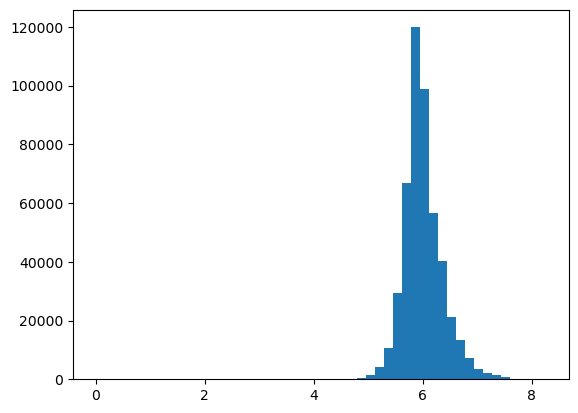

In [18]:

plt.hist(np.log(y), bins=50)

(array([1.4000e+01, 6.7000e+01, 9.6000e+01, 1.2080e+03, 4.9050e+03,
        1.0584e+04, 2.6625e+04, 4.8658e+04, 7.9580e+04, 7.1760e+04,
        5.2461e+04, 4.4012e+04, 3.3510e+04, 1.7725e+04, 2.1034e+04,
        1.3521e+04, 1.1327e+04, 9.1220e+03, 3.0280e+03, 5.4280e+03,
        3.5800e+03, 3.4580e+03, 1.9030e+03, 2.1160e+03, 1.8720e+03,
        1.7990e+03, 1.0400e+03, 3.9800e+02, 1.0370e+03, 3.7600e+02,
        1.0930e+03, 1.9300e+02, 5.1900e+02, 7.9600e+02, 3.5300e+02,
        4.3000e+02, 4.1000e+01, 1.3800e+02, 5.4600e+02, 1.0900e+02,
        5.9000e+01, 2.0800e+02, 1.3100e+02, 1.6700e+02, 1.2500e+02,
        1.1000e+01, 1.9900e+02, 7.2000e+01, 8.1000e+01, 5.9000e+01,
        1.6000e+01, 2.2300e+02, 1.0000e+01, 4.5000e+01, 5.0000e+00,
        2.1000e+01, 9.0000e+01, 2.7000e+01, 3.2000e+01, 3.0000e+00,
        9.0000e+00, 3.3000e+01, 7.0000e+00, 8.0000e+00, 1.0400e+02,
        3.0000e+00, 2.3000e+01, 7.0000e+00, 1.0000e+00, 1.2000e+01,
        1.9000e+01, 2.0000e+01, 2.0000e+00, 2.00

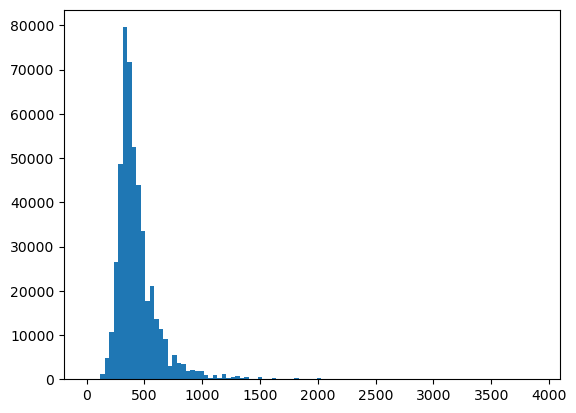

In [19]:
plt.hist((y), bins=100)

In [20]:
X_train.columns
# X_train['lga']

Index(['num_bedrooms', 'num_bathrooms', 'parking', 'nearst_train_station_dist',
       'year', 'month', 'num_primary', 'num_secondary_public',
       'num_secondary_private', 'num_secondary_catholic', 'num_edu_centre',
       'v_high_vcaa', 'high_vcaa', 'good_vcaa',
       'property_type_apartment / unit / flat', 'property_type_duplex',
       'property_type_duplex-semi-detached', 'property_type_house',
       'property_type_retirement living', 'property_type_serviced apartment',
       'property_type_studio', 'property_type_townhouse',
       'property_type_villa', 'Rate per 100,000 population', 'lga_population',
       'avg_distance_to_cbd', 'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

Mean Squared Error: 42157.77328582746
R2 Score: 0.4112113574842471


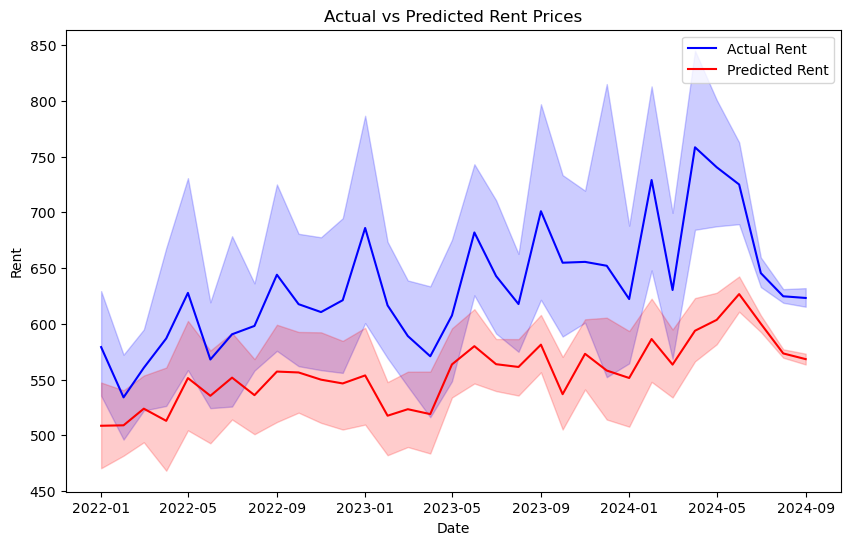

In [21]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_test, label='Actual Rent', color='blue')
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_pred, label='Predicted Rent', color='red')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()




In [22]:

rent1 = y_test.rename('rent1')

result = pd.concat([rent1.reset_index(drop=True), pd.Series(y_pred, name='predicted_rent').reset_index(drop=True), X_test.reset_index(drop=True),y_test.reset_index(drop=True),df_reg_sub_test.reset_index(drop=True)], axis=1)
print(result.head())

   rent1  predicted_rent  num_bedrooms  num_bathrooms  parking  \
0  510.0      379.990755           3.0            1.0      2.0   
1  460.0      378.845671           2.0            1.0      1.0   
2  720.0      599.746226           3.0            2.0      4.0   
3  610.0      533.817074           4.0            2.0      2.0   
4  550.0      537.943005           2.0            1.0      0.0   

   nearst_train_station_dist  year  month  num_primary  num_secondary_public  \
0                   0.323394  2022      1            8                     3   
1                   0.308021  2022      1            7                     2   
2                   0.302302  2022      1            5                     1   
3                   4.479085  2022      1            6                     2   
4                   1.582158  2022      1            4                     0   

   ...  property_type_studio  property_type_townhouse  property_type_villa  \
0  ...                 False                

In [23]:
result[['rent','rent1']]

,rent,rent1
0,510.0,510.0
1,460.0,460.0
2,720.0,720.0
3,610.0,610.0
4,550.0,550.0
...,...,...
13115,620.0,620.0
13116,580.0,580.0
13117,1095.0,1095.0
13118,720.0,720.0


In [24]:
result[result['suburb'] == 'abbotsford']

,rent1,predicted_rent,num_bedrooms,num_bathrooms,parking,nearst_train_station_dist,year,month,num_primary,num_secondary_public,...,property_type_studio,property_type_townhouse,property_type_villa,"Rate per 100,000 population",lga_population,avg_distance_to_cbd,avg_rent_by_suburb,median_rent_by_suburb,rent,suburb
1369,915.0,723.086038,3.0,2.0,1.0,0.299541,2023,9,2,0,...,False,True,False,12913.553895,97448.000000,4.026649,505.134401,480.0,915.0,abbotsford
1607,780.0,708.011401,3.0,2.0,2.0,1.383839,2024,1,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,780.0,abbotsford
1779,1800.0,865.019182,4.0,3.0,2.0,0.741504,2024,3,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,1800.0,abbotsford
1860,900.0,640.940475,2.0,2.0,1.0,1.356315,2024,4,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,900.0,abbotsford
2066,800.0,641.876836,2.0,2.0,1.0,1.495632,2024,5,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,800.0,abbotsford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12413,430.0,499.059053,1.0,1.0,1.0,0.581582,2024,9,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,430.0,abbotsford
12491,480.0,489.749504,1.0,1.0,0.0,1.356315,2024,9,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,480.0,abbotsford
12620,580.0,558.393840,2.0,1.0,1.0,1.263224,2024,9,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,580.0,abbotsford
12668,520.0,490.069149,1.0,1.0,0.0,1.495632,2024,9,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,520.0,abbotsford


## Train and test the ridge regression model 

### evaluate the rankings for features 

Mean Squared Error: 42157.704876096075
R2 Score: 0.4112123129159442
                                       Coefficient  Absolute Coefficient
num_bathrooms                            85.416017             85.416017
property_type_studio                     84.338331             84.338331
num_bedrooms                             57.770202             57.770202
property_type_apartment / unit / flat   -43.836848             43.836848
property_type_villa                     -43.066717             43.066717
property_type_house                     -29.775093             29.775093
property_type_retirement living          27.457801             27.457801
property_type_serviced apartment         15.678789             15.678789
year                                     13.432809             13.432809
parking                                  11.087126             11.087126
num_edu_centre                           10.739293             10.739293
good_vcaa                                 9.253270      

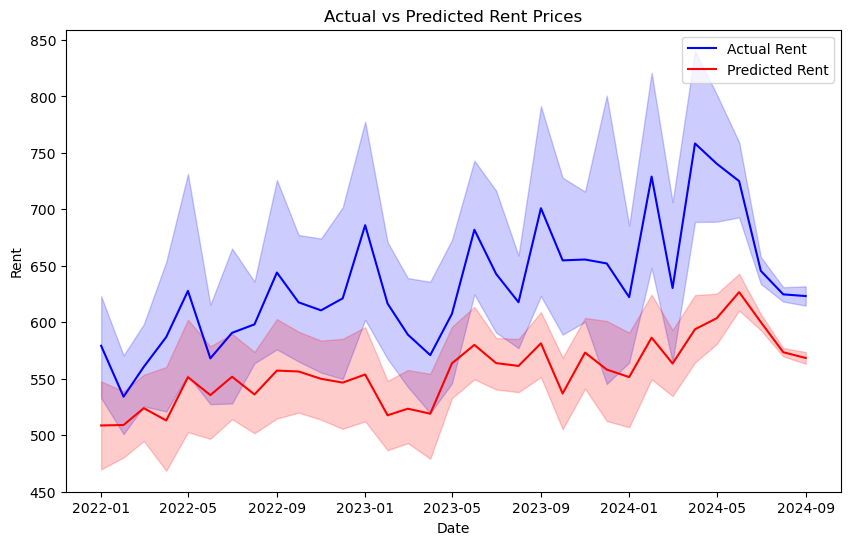

In [25]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


# find the most significant features
coefficients = pd.DataFrame(ridge_model.coef_, index=X_train.columns, columns=['Coefficient'])
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute Coefficient', ascending=False)
print(coefficients)

plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_test, label='Actual Rent', color='blue')
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_pred, label='Predicted Rent', color='red')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()


## 

## Train and Test the Random forrest and find the important features

Mean Squared Error: 40480.35269041298
R2 Score: 0.4346387379724399
Feature ranking:
1. feature avg_rent_by_suburb (0.32043680606264585)
2. feature num_bathrooms (0.20401970066991562)
3. feature nearst_train_station_dist (0.15575582426092885)
4. feature num_bedrooms (0.08566787633292805)
5. feature avg_distance_to_cbd (0.0503912961262393)
6. feature month (0.04359082276911154)
7. feature lga_population (0.026870360070574268)
8. feature parking (0.02295245194226727)
9. feature median_rent_by_suburb (0.02162061528215492)
10. feature Rate per 100,000 population (0.018248849801645636)
11. feature year (0.009836299314227425)
12. feature property_type_apartment / unit / flat (0.00642968722705862)
13. feature num_primary (0.004966938175309064)
14. feature property_type_house (0.004910762602089911)
15. feature property_type_townhouse (0.0041032012948253975)
16. feature v_high_vcaa (0.0040220408173066435)
17. feature num_secondary_private (0.003548192489639966)
18. feature num_secondary_public (

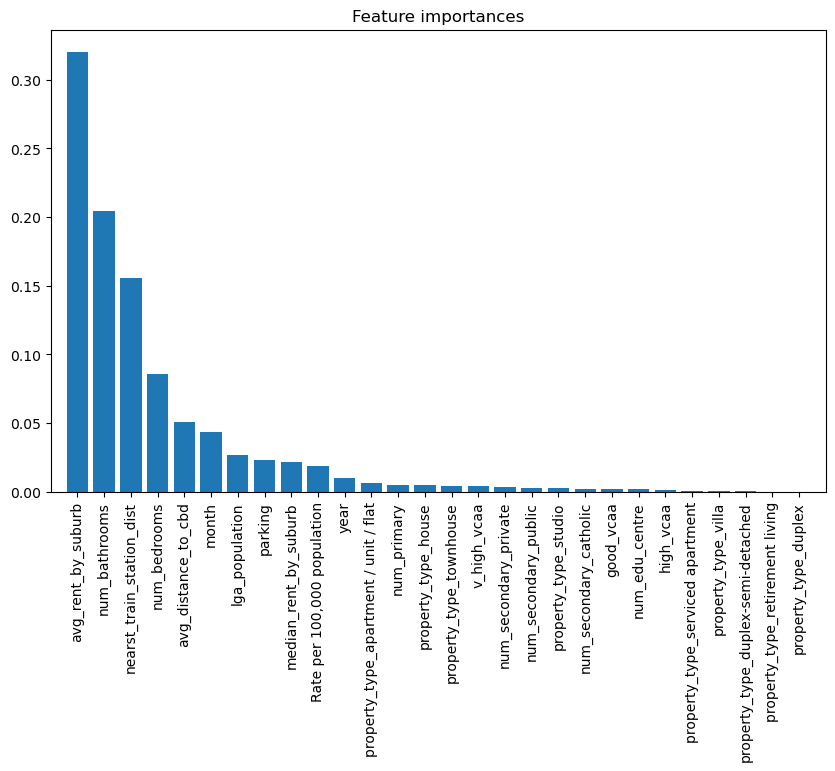

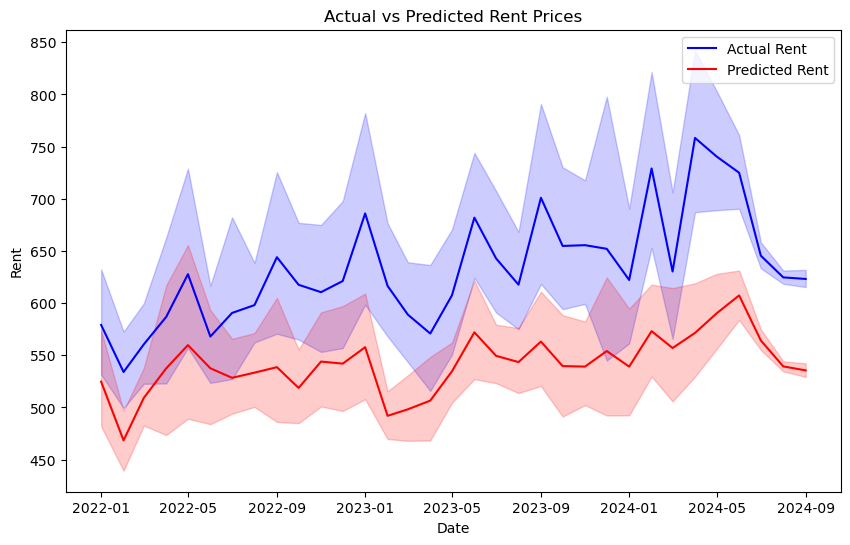

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


# find the most significant features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({importances[indices[f]]})")

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_test, label='Actual Rent', color='blue')
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_pred, label='Predicted Rent', color='red')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()

## Train and Test the XGboost and find the important features

Mean Squared Error: 28118.35811248478
R2 Score: 0.6072902192776055
Feature ranking:
1. feature avg_rent_by_suburb (0.33714067935943604)
2. feature num_bathrooms (0.1790117621421814)
3. feature num_bedrooms (0.06001481041312218)
4. feature avg_distance_to_cbd (0.05814068391919136)
5. feature property_type_apartment / unit / flat (0.04200300574302673)
6. feature num_secondary_catholic (0.03633327782154083)
7. feature median_rent_by_suburb (0.031181754544377327)
8. feature v_high_vcaa (0.030589932575821877)
9. feature property_type_studio (0.025097914040088654)
10. feature property_type_house (0.022217368707060814)
11. feature lga_population (0.020999986678361893)
12. feature num_secondary_private (0.020696502178907394)
13. feature high_vcaa (0.015768006443977356)
14. feature nearst_train_station_dist (0.015516501851379871)
15. feature parking (0.015102602541446686)
16. feature Rate per 100,000 population (0.01500758621841669)
17. feature year (0.014024345204234123)
18. feature num_edu_ce

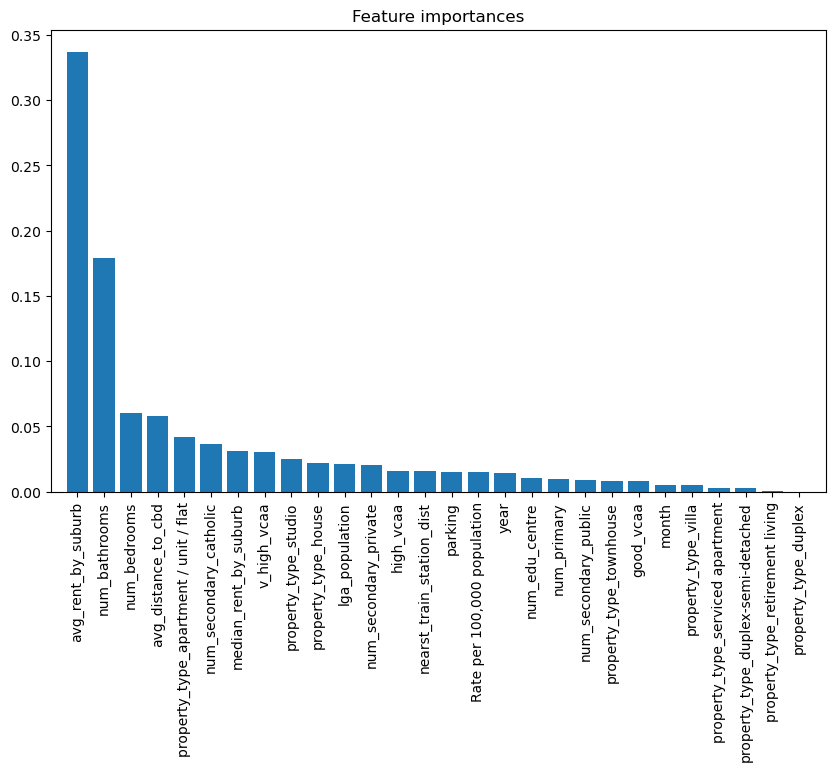

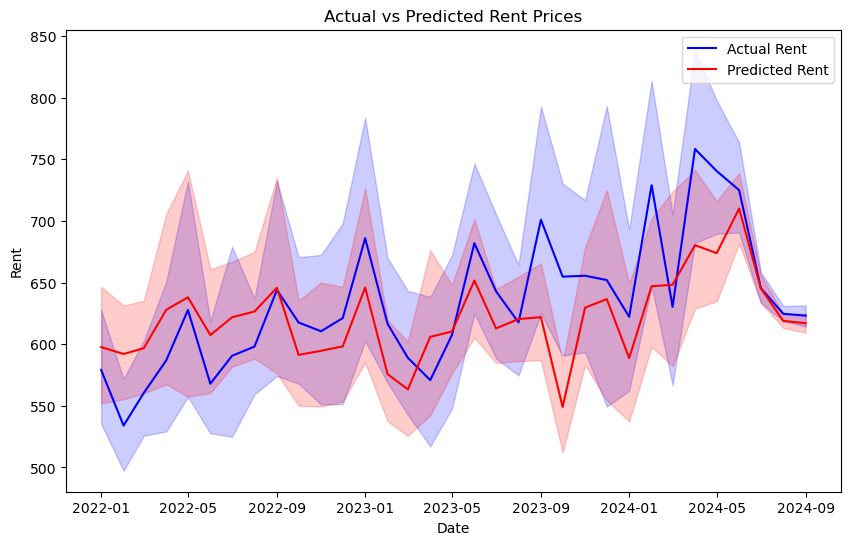

In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Initialize the XGBRegressor
xgb_model = XGBRegressor(n_estimators=200, random_state=42, reg_alpha=0.1, reg_lambda=1.0)

# Train the model
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

# Display feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({importances[indices[f]]})")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Plot actual vs predicted rent prices
plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_test, label='Actual Rent', color='blue')
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_pred, label='Predicted Rent', color='red')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()


## Preparing data to forcast

In [28]:
lga_pop = pd.read_csv('../data/curated/lga_pop.csv')
crime_df = pd.read_csv('../data/curated/crime_by_lga.csv')


In [29]:
crime_df

,Unnamed: 0,Local Government Area,Year,"Rate per 100,000 population"
0,0,alpine,2015,3572.290611
1,1,alpine,2016,3378.915567
2,2,alpine,2017,2987.309845
3,3,alpine,2018,3899.547652
4,4,alpine,2019,4657.470552
...,...,...,...,...
1022,788,yarriambiack,2023,7168.570981
1023,789,yarriambiack,2024,8609.398034
1024,868,yarriambiack,2025,8391.308656
1025,947,yarriambiack,2026,8525.497956


In [30]:
crime_df.drop('Unnamed: 0', axis=1, inplace=True)
crime_df.rename(columns={'Local Government Area':'lga','Year':'year'}, inplace=True)

crime_df_2025 = crime_df[crime_df['year'] == 2025]
crime_df_2025 = crime_df_2025.drop('year', axis=1)

crime_df_2026 = crime_df[crime_df['year'] == 2026]
crime_df_2026 = crime_df_2026.drop('year', axis=1)

crime_df_2027 = crime_df[crime_df['year'] == 2027]
crime_df_2027 = crime_df_2027.drop('year', axis=1)

In [31]:


lga_pop_2025 = lga_pop[lga_pop['year'] == 2025] 
lga_pop_2025 = lga_pop_2025.drop('year', axis=1)


lga_pop_2026 = lga_pop[lga_pop['year'] == 2026]
lga_pop_2026 = lga_pop_2026.drop('year', axis=1)


lga_pop_2027 = lga_pop[lga_pop['year'] == 2027]
lga_pop_2027 = lga_pop_2027.drop('year', axis=1)

In [32]:
df.columns

Index(['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking',
       'nearst_train_station_dist', 'year', 'month', 'num_primary',
       'num_secondary_public', 'num_secondary_private',
       'num_secondary_catholic', 'num_edu_centre', 'v_high_vcaa', 'high_vcaa',
       'good_vcaa', 'property_type_apartment / unit / flat',
       'property_type_duplex', 'property_type_duplex-semi-detached',
       'property_type_house', 'property_type_retirement living',
       'property_type_serviced apartment', 'property_type_studio',
       'property_type_townhouse', 'property_type_villa', 'lga',
       'Rate per 100,000 population', 'lga_population', 'avg_distance_to_cbd',
       'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

In [33]:

df_forcast = df.copy()


# df_reg_sub = df_forcast['suburb']
# df.drop(['suburb'], axis=1, inplace=True)



# df_reg.drop(['lga'], axis=1, inplace=True)

X_train = df.drop('rent', axis=1)
X_train.drop(['lga',"suburb"], axis=1, inplace=True)

y_train = df['rent']




df_forcast_2025 = df.copy()
df_forcast_2025['year'] = 2025

X_forcast_2025 = df_forcast_2025.drop(["lga_population","Rate per 100,000 population"], axis=1)
X_forcast_2025 = pd.merge(X_forcast_2025, lga_pop_2025, on='lga', how='left')
X_forcast_2025 = pd.merge(X_forcast_2025, crime_df_2025, on='lga', how='left')
X_2025_suburb = X_forcast_2025['suburb']
X_2025_rent = df_forcast_2025['rent']

X_forcast_2025.drop(['lga','suburb','rent'], axis=1, inplace=True)

# ----------------------------

df_forcast_2026 = df.copy()
df_forcast_2026['year'] = 2026

X_forcast_2026 = df_forcast_2026.drop(["lga_population","Rate per 100,000 population"], axis=1)
X_forcast_2026 = pd.merge(X_forcast_2026, lga_pop_2026, on='lga', how='left')
X_forcast_2026 = pd.merge(X_forcast_2026, crime_df_2026, on='lga', how='left')
X_2026_suburb = X_forcast_2026['suburb']
X_2026_rent = df_forcast_2026['rent']


X_forcast_2026.drop(['lga','suburb','rent'], axis=1, inplace=True)

#  ----------------------------

df_forcast_2027 = df.copy()
df_forcast_2027['year'] = 2027

X_forcast_2027 = df_forcast_2027.drop(["lga_population","Rate per 100,000 population"], axis=1)
X_forcast_2027 = pd.merge(X_forcast_2027, lga_pop_2027, on='lga', how='left')
X_forcast_2027 = pd.merge(X_forcast_2027, crime_df_2027, on='lga', how='left')
X_2027_suburb = X_forcast_2027['suburb']
X_2027_rent = df_forcast_2027['rent']


X_forcast_2027.drop(['lga','suburb','rent'], axis=1, inplace=True)

In [34]:
X_train

,num_bedrooms,num_bathrooms,parking,nearst_train_station_dist,year,month,num_primary,num_secondary_public,num_secondary_private,num_secondary_catholic,...,property_type_retirement living,property_type_serviced apartment,property_type_studio,property_type_townhouse,property_type_villa,"Rate per 100,000 population",lga_population,avg_distance_to_cbd,avg_rent_by_suburb,median_rent_by_suburb
2351,3.0,1.0,1.0,33.970773,2015,1,3,1,1,0,...,False,False,False,False,False,8223.212522,232926.000000,60.414872,270.375717,270.0
3910,2.0,1.0,1.0,1.535148,2015,1,1,0,0,0,...,False,False,False,False,False,7389.227044,91674.000000,19.484784,368.674419,360.0
18848,2.0,2.0,1.0,1.101459,2015,1,1,1,0,0,...,False,False,False,False,False,25240.370565,136872.000000,1.314855,674.013677,600.0
20349,2.0,2.0,1.0,0.264072,2015,1,4,0,2,0,...,False,False,False,False,False,3965.763000,145924.000000,12.171181,441.264183,390.0
22522,2.0,1.0,1.0,0.923387,2015,1,6,1,2,0,...,False,False,False,False,False,3767.031181,174753.000000,6.294578,490.883340,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484542,2.0,2.0,1.0,0.641664,2024,9,2,1,1,1,...,False,False,False,False,False,5698.885766,179469.707553,14.217259,449.932146,430.0
484546,4.0,2.0,2.0,7.170467,2024,9,9,2,2,1,...,False,False,False,False,False,5985.753865,337384.401708,25.782024,372.621287,360.0
484547,4.0,3.0,3.0,0.867788,2024,9,6,0,1,1,...,False,False,False,False,False,9917.831843,111445.270259,9.512496,547.427076,453.0
484548,4.0,3.0,1.0,1.485309,2024,9,3,1,0,0,...,False,False,False,True,False,7444.876870,270240.488598,14.994288,381.800623,370.0


In [35]:
len(X_forcast_2025.columns)

28

## Forcasting using Random forest

In [36]:
X_train.columns

Index(['num_bedrooms', 'num_bathrooms', 'parking', 'nearst_train_station_dist',
       'year', 'month', 'num_primary', 'num_secondary_public',
       'num_secondary_private', 'num_secondary_catholic', 'num_edu_centre',
       'v_high_vcaa', 'high_vcaa', 'good_vcaa',
       'property_type_apartment / unit / flat', 'property_type_duplex',
       'property_type_duplex-semi-detached', 'property_type_house',
       'property_type_retirement living', 'property_type_serviced apartment',
       'property_type_studio', 'property_type_townhouse',
       'property_type_villa', 'Rate per 100,000 population', 'lga_population',
       'avg_distance_to_cbd', 'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

In [37]:
X_forcast_2025.columns

Index(['num_bedrooms', 'num_bathrooms', 'parking', 'nearst_train_station_dist',
       'year', 'month', 'num_primary', 'num_secondary_public',
       'num_secondary_private', 'num_secondary_catholic', 'num_edu_centre',
       'v_high_vcaa', 'high_vcaa', 'good_vcaa',
       'property_type_apartment / unit / flat', 'property_type_duplex',
       'property_type_duplex-semi-detached', 'property_type_house',
       'property_type_retirement living', 'property_type_serviced apartment',
       'property_type_studio', 'property_type_townhouse',
       'property_type_villa', 'avg_distance_to_cbd', 'avg_rent_by_suburb',
       'median_rent_by_suburb', 'lga_population',
       'Rate per 100,000 population'],
      dtype='object')

In [38]:
X_forcast_2025 = X_forcast_2025[X_train.columns]
X_forcast_2026 = X_forcast_2026[X_train.columns]
X_forcast_2027 = X_forcast_2027[X_train.columns]

In [39]:
from sklearn.ensemble import RandomForestRegressor

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

xgb_model = XGBRegressor(n_estimators=500, random_state=42, reg_alpha=0.1, reg_lambda=1.0)

xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [40]:
y_pred_2025 = xgb_model.predict(X_forcast_2025)
y_pred_2026 = xgb_model.predict(X_forcast_2026)
y_pred_2027 = xgb_model.predict(X_forcast_2027)

Feature ranking:
1. feature avg_rent_by_suburb (0.275932639837265)
2. feature num_bathrooms (0.1622692197561264)
3. feature v_high_vcaa (0.06848254799842834)
4. feature avg_distance_to_cbd (0.05892515927553177)
5. feature num_bedrooms (0.0579969584941864)
6. feature property_type_studio (0.04490494355559349)
7. feature property_type_apartment / unit / flat (0.042287975549697876)
8. feature year (0.04140375927090645)
9. feature median_rent_by_suburb (0.033784836530685425)
10. feature num_secondary_private (0.023814961314201355)
11. feature lga_population (0.022165928035974503)
12. feature high_vcaa (0.018914418295025826)
13. feature property_type_house (0.018167950212955475)
14. feature num_secondary_catholic (0.015563394874334335)
15. feature Rate per 100,000 population (0.01403459720313549)
16. feature nearst_train_station_dist (0.013983914628624916)
17. feature parking (0.013698088005185127)
18. feature property_type_townhouse (0.013225743547081947)
19. feature num_secondary_public (

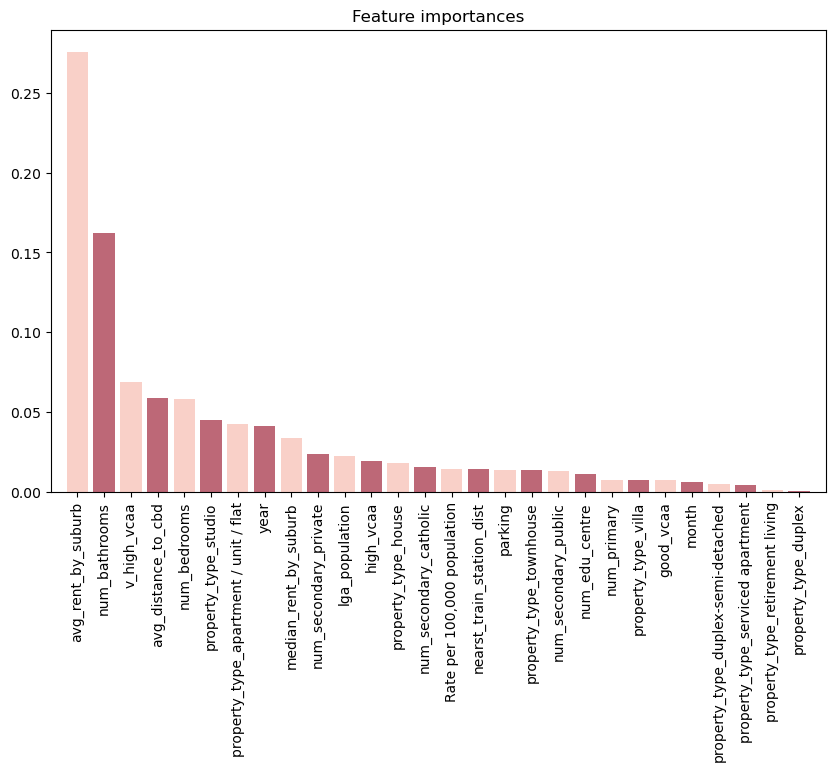

In [41]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_forcast_2025.columns

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({importances[indices[f]]})")


custom_colors = ['#f9d0c8', '#bd6877']

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color=custom_colors)
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()



In [42]:

forcast_2025 = pd.concat([X_2025_rent.reset_index(drop=True),X_2025_suburb.reset_index(drop=True), pd.Series(y_pred_2025, name='predicted_rent').reset_index(drop=True), X_forcast_2025.reset_index(drop=True)], axis=1)

In [43]:
forcast_2026 = pd.concat([X_2026_rent.reset_index(drop=True),X_2026_suburb.reset_index(drop=True), pd.Series(y_pred_2026, name='predicted_rent').reset_index(drop=True), X_forcast_2026.reset_index(drop=True)], axis=1)

In [44]:
forcast_2027 = pd.concat([X_2027_rent.reset_index(drop=True),X_2027_suburb.reset_index(drop=True), pd.Series(y_pred_2027, name='predicted_rent').reset_index(drop=True), X_forcast_2027.reset_index(drop=True)], axis=1)

In [45]:
aggregated_2026 = forcast_2026[['suburb','predicted_rent','year','rent']].groupby('suburb')['predicted_rent'].mean()
aggregated_2025 = forcast_2025[['suburb','predicted_rent','year','rent']].groupby('suburb')['predicted_rent'].mean()
aggregated_2027 = forcast_2027[['suburb','predicted_rent','year','rent']].groupby('suburb')['predicted_rent'].mean()

In [46]:
aggregated_2025 = aggregated_2025.reset_index()
aggregated_2025['year'] = 2025


aggregated_2026 = aggregated_2026.reset_index()
aggregated_2026['year'] = 2026

aggregated_2027 = aggregated_2027.reset_index()
aggregated_2027['year'] = 2027

In [47]:
aggregated_2025

,suburb,predicted_rent,year
0,abbotsford,689.704529,2025
1,aberfeldie,694.407166,2025
2,airport west,576.851501,2025
3,albanvale,497.883026,2025
4,albert park,1180.227539,2025
...,...,...,...
583,yarragon,489.035767,2025
584,yarram,420.348206,2025
585,yarraville,669.289612,2025
586,yarrawonga,493.491150,2025


In [48]:
aggregated_2025.sort_values(by='suburb', ascending=False, inplace=True)

In [49]:
aggregated_2027.sort_values(by='suburb', ascending=False, inplace=True)

In [50]:
aggregated_2026.sort_values(by='suburb', ascending=False, inplace=True)

In [51]:
diff_2025_2027 = pd.merge(aggregated_2025, aggregated_2027, on='suburb', how='inner')

diff_2025_2027['growth(%)'] = ((diff_2025_2027['predicted_rent_y'] - diff_2025_2027['predicted_rent_x'])/diff_2025_2027['predicted_rent_x'])*100

diff_2025_2027

,suburb,predicted_rent_x,year_x,predicted_rent_y,year_y,growth(%)
0,yea,439.290619,2025,439.290619,2027,0.000000
1,yarrawonga,493.491150,2025,494.852783,2027,0.275918
2,yarraville,669.289612,2025,698.839172,2027,4.415063
3,yarram,420.348206,2025,420.348206,2027,0.000000
4,yarragon,489.035767,2025,490.582458,2027,0.316274
...,...,...,...,...,...,...
583,albert park,1180.227539,2025,1180.227539,2027,0.000000
584,albanvale,497.883026,2025,497.883026,2027,0.000000
585,airport west,576.851501,2025,576.851501,2027,0.000000
586,aberfeldie,694.407166,2025,694.407166,2027,0.000000


In [52]:
ranking = diff_2025_2027.sort_values(by='growth(%)', ascending=False)

ranking[ranking['suburb'] == 'doncaster']

,suburb,predicted_rent_x,year_x,predicted_rent_y,year_y,growth(%)
416,doncaster,669.156372,2025,664.65509,2027,-0.67268


In [70]:
# ranking[ranking['suburb'] == 'box hill']

,suburb,predicted_rent_x,year_x,predicted_rent_y,year_y,growth(%)
519,box hill,616.245789,2025,616.237793,2027,-0.001297


In [53]:
top_ten_growth_suburbs = ranking[0:10]

In [54]:
highest_growth_suburb = top_ten_growth_suburbs[['suburb','growth(%)']]

# now remove the index part 
highest_growth_suburb.reset_index(drop=True, inplace=True)


In [55]:
highest_growth_suburb

,suburb,growth(%)
0,brooklyn,5.530499
1,numurkah,5.244390
2,pakenham,4.459053
3,yarraville,4.415063
4,south kingsville,4.376797
5,officer,4.265609
6,altona north,4.206747
7,parkdale,4.199463
8,seddon,3.728545
9,maribyrnong,3.538973


In [56]:
top_ten_sub = list(top_ten_growth_suburbs['suburb'].unique())


In [57]:
top_ten_growth_suburbs

,suburb,predicted_rent_x,year_x,predicted_rent_y,year_y,growth(%)
507,brooklyn,543.607483,2025,573.671692,2027,5.530499
181,numurkah,393.035309,2025,413.647614,2027,5.244390
170,pakenham,579.781921,2025,605.634705,2027,4.459053
2,yarraville,669.289612,2025,698.839172,2027,4.415063
110,south kingsville,601.810608,2025,628.150635,2027,4.376797
174,officer,615.638733,2025,641.899475,2027,4.265609
576,altona north,612.354187,2025,638.114380,2027,4.206747
169,parkdale,678.025879,2025,706.499329,2027,4.199463
119,seddon,649.204163,2025,673.410034,2027,3.728545
254,maribyrnong,572.351685,2025,592.607056,2027,3.538973


In [58]:
df_sub_timeline  = pd.concat([aggregated_2025, aggregated_2026, aggregated_2027], axis=0)

df_sub_timeline = df_sub_timeline[df_sub_timeline['suburb'].isin(top_ten_sub)]

df_past_timeline = df[df['suburb'].isin(top_ten_sub)]

df_past_timeline = df_past_timeline[['suburb','year','rent']].groupby(['suburb','year']).mean()


In [59]:
df_past_timeline = df_past_timeline.reset_index()


In [60]:
df_past_timeline 

,suburb,year,rent
0,altona north,2015,401.497326
1,altona north,2016,415.474684
2,altona north,2017,439.244186
3,altona north,2021,520.000000
4,altona north,2022,631.000000
...,...,...,...
62,yarraville,2020,600.000000
63,yarraville,2021,575.000000
64,yarraville,2022,642.500000
65,yarraville,2023,648.333333


In [61]:
df_sub_timeline
df_sub_timeline.rename(columns={'predicted_rent':'rent'}, inplace=True)

In [62]:
df_join_top_ten = pd.concat([df_past_timeline, df_sub_timeline], axis=0)
df_join_top_ten

,suburb,year,rent
0,altona north,2015,401.497326
1,altona north,2016,415.474684
2,altona north,2017,439.244186
3,altona north,2021,520.000000
4,altona north,2022,631.000000
...,...,...,...
413,officer,2027,641.899475
406,numurkah,2027,413.647614
333,maribyrnong,2027,592.607056
80,brooklyn,2027,573.671692


In [63]:
df_join_top_ten[df_join_top_ten['suburb'] == 'hillside']

,suburb,year,rent


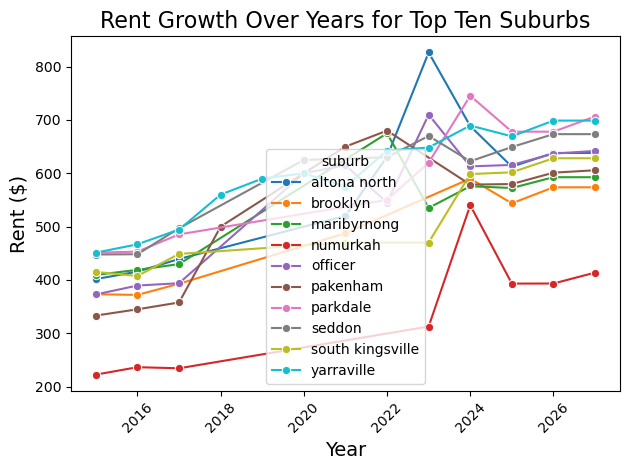

In [64]:
# plot the top ten suburbs and there rent growth over the years, fill in the missing values with the average of the previous and next year


sns.lineplot(data=df_join_top_ten, x='year', y='rent', hue='suburb', marker='o')

# Set the title and labels
plt.title('Rent Growth Over Years for Top Ten Suburbs', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Rent ($)', fontsize=14)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

In [65]:
u= df.groupby(['suburb',"year"]).count()
u = u.reset_index()
u[u['suburb'] == 'hillside']

,suburb,year,rent,num_bedrooms,num_bathrooms,parking,nearst_train_station_dist,month,num_primary,num_secondary_public,...,property_type_serviced apartment,property_type_studio,property_type_townhouse,property_type_villa,lga,"Rate per 100,000 population",lga_population,avg_distance_to_cbd,avg_rent_by_suburb,median_rent_by_suburb
1442,hillside,2015,192,192,192,192,192,192,192,192,...,192,192,192,192,192,192,192,192,192,192
1443,hillside,2016,167,167,167,167,167,167,167,167,...,167,167,167,167,167,167,167,167,167,167
1444,hillside,2017,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186
1445,hillside,2023,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1446,hillside,2024,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [66]:
ranking.to_csv('../data/curated/growth_rate_suburb.csv')